# Predicting willingness to donate blood: A machine learning approach

This notebook is submitted in support of the thesis with the same title.

- Unless otherwise stated our level of significance for statistical tests is 0.05
- This notebook's working ssumption is that the relevant packages especially *mlxtend* are already installed on your machine.
- corollary to the above assumption, the assumed working environment is Jupyter Notebook

## Data Preparation and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import imblearn
import seaborn as sns

import math
import matplotlib.pyplot as plt
from inspect import signature
#set seed for reproducibility
np.random.seed(3896127045)

In [2]:
#Access the stata data file
df = pd.read_stata('ZA5931_v3-0-0.dta') 

Do not forget to attach the stata file 

In [3]:
#checking column indices to find indice of interest
{df.columns.get_loc(c):c for idx, c in enumerate(df.columns)} 

{0: 'studyno1',
 1: 'studyno2',
 2: 'doi',
 3: 'version',
 4: 'edition',
 5: 'survey',
 6: 'caseid',
 7: 'uniqid',
 8: 'serialid',
 9: 'tnscntry',
 10: 'country',
 11: 'isocntry',
 12: 'w1',
 13: 'de',
 14: 'w3',
 15: 'gb',
 16: 'w4',
 17: 'eu6',
 18: 'w5',
 19: 'eu9',
 20: 'w6',
 21: 'eu10',
 22: 'w7',
 23: 'eu12_1',
 24: 'w8',
 25: 'eu12_2',
 26: 'w9',
 27: 'eu_nms3',
 28: 'w10',
 29: 'eu15',
 30: 'w11',
 31: 'eu_nms10',
 32: 'w13',
 33: 'eu25',
 34: 'w14',
 35: 'euac2',
 36: 'w18',
 37: 'euac3',
 38: 'w15',
 39: 'eu27',
 40: 'w22',
 41: 'eu28',
 42: 'w23',
 43: 'eu_nms12',
 44: 'w24',
 45: 'euroz15',
 46: 'w29',
 47: 'euronz15',
 48: 'w30',
 49: 'euroz16',
 50: 'w81',
 51: 'euronz16',
 52: 'w82',
 53: 'euroz17',
 54: 'w89',
 55: 'eurnz17a',
 56: 'w90',
 57: 'eurnz17b',
 58: 'w93',
 59: 'euroz18',
 60: 'w98',
 61: 'eurnz18a',
 62: 'w99',
 63: 'eurnz18b',
 64: 'w83',
 65: 'eurnz18c',
 66: 'w84',
 67: 'eu_nms13',
 68: 'w94',
 69: 'cntrgr100',
 70: 'w100',
 71: 'wextra',
 72: 'q1_1',
 7

In [4]:
#Check Despriptives of target variables
df["qe1_1"].value_counts()

No, you have not donated in the past but you would be prepared to donate in the future        8591
No, you have not donated in the past and you would not be prepared to donate in the future    8251
Yes, you have donated in the past you and would be prepared to donate in the future           7238
Yes, you have donated in the past but you would not be prepared to donate in the future       3002
Name: qe1_1, dtype: int64

In [5]:
# Desriptives of demographic variables
df['d10'].value_counts()

Female    15588
Male      12280
Name: d10, dtype: int64

In [6]:
df['d11r1'].value_counts()

55 years and older    12401
40 - 54 years          6862
25 - 39 years          5964
15 - 24 years          2641
Name: d11r1, dtype: int64

In [7]:
df['d7r2'].value_counts()

(Re-)Married/Single with partner (1-8 in d7)    17765
Unmarried (9-10 in d7)                           4625
Widowed (13-14 in d7)                            2940
Divorced or separated (11-12 in d7)              2268
Other (SPONT.)                                    196
Name: d7r2, dtype: int64

In [8]:
# Subset the required columns into a new dataframe
df1 = df.iloc[0:,516: 676]
df1['tnscntry'] =df['tnscntry']
df1['d40t_r'] =df['d40t_r']
df1['d25'] =df['d25']
df1['d60'] =df['d60']

In [9]:
#Use Age to select respondents eligible for donating blood
ages = set(df1['d11'])
ages #checking out the odd figures


{'15 years',
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 '98 years',
 '99 years (and older)'}

In [10]:
# fixing the anomalies in the column
df1['d11'] = df1['d11'].replace('15 years', 15)
df1['d11'] = df1['d11'].replace('98 years', 98)
df1['d11'] = df1['d11'].replace('99 years (and older)',99)
df1['d11'] #check the corrected column

0        76
1        35
2        76
3        22
4        43
         ..
27863    29
27864    54
27865    29
27866    54
27867    54
Name: d11, Length: 27868, dtype: int64

In [11]:
#remove cases ineligible for donations because of age i.e. outside 15 to 70 years range
df1 = df1[df1['d11'] >= 15]
df1 = df1[df1['d11'] <= 70]


In [12]:
# check the noumber of observations to find your coverage on the sample after removing ineligible individuals
len(df1['d11'])

23488

In [13]:
# Check our dataframe again, this time to select our variables of interest
list(df1.columns.values)

['qe1_1',
 'qe1_2',
 'qe1_3',
 'qe1_4',
 'qe1_5',
 'qe1_6',
 'qe1t_1',
 'qe1t_2',
 'qe1t_3',
 'qe1t_4',
 'qe2_1',
 'qe2_2',
 'qe2_3',
 'qe2_4',
 'qe2t',
 'qe3_1',
 'qe3_2',
 'qe3_3',
 'qe3_4',
 'qe3_5',
 'qe3_6',
 'qe3_7',
 'qe4_1',
 'qe4_2',
 'qe4_3',
 'qe4_4',
 'qe4_5',
 'qe4_6',
 'qe4_7',
 'qe5a_1',
 'qe5a_2',
 'qe5a_3',
 'qe5a_4',
 'qe5a_5',
 'qe5a_6',
 'qe5a_7',
 'qe5a_8',
 'qe5a_9',
 'qe5a_10',
 'qe5b_1',
 'qe5b_2',
 'qe5b_3',
 'qe5b_4',
 'qe5b_5',
 'qe5b_6',
 'qe5b_7',
 'qe5b_8',
 'qe5b_9',
 'qe5b_10',
 'qe5b_11',
 'qe5b_12',
 'qe6_1',
 'qe6_2',
 'qe6_3',
 'qe6_4',
 'qe6_5',
 'qe6_6',
 'qe6_7',
 'qe6_8',
 'qe6_9',
 'qe6_10',
 'qe6_11',
 'qe6_12',
 'qe6t',
 'qe7_1',
 'qe7_2',
 'qe8_1',
 'qe8_2',
 'qe8_3',
 'qe8_4',
 'qe8_5',
 'qe8_6',
 'qe8_7',
 'qe8_8',
 'qe8_9',
 'qe8_10',
 'qe8_11',
 'qe9_1',
 'qe9_2',
 'qe9_3',
 'qe9_4',
 'qe9_5',
 'qe9_6',
 'qe9_7',
 'qe9_8',
 'qe9_9',
 'qe9_10',
 'qe9_11',
 'qe9_12',
 'qe9_13',
 'qe9t',
 'qe10_1',
 'qe10_2',
 'qe10_3',
 'qe10_4',
 'qe10_5',

In [14]:
#recode variables in the target to 0 and 1
df1['qe1_1'] =df1['qe1_1'].map({'No, you have not donated in the past and you would not be prepared to donate in the future': 0, 'Yes, you have donated in the past but you would not be prepared to donate in the future': 0,'No, you have not donated in the past but you would be prepared to donate in the future':1,'Yes, you have donated in the past you and would be prepared to donate in the future':1})
#Sort out the NaNs in the rest of the dataset
df1 = df1[['tnscntry','qe1_1','qe6_1','qe6_2','qe7_1','qe8_1','qe8_2','qe8_3','qe8_4','qe8_5','qe8_6','qe8_7','qe8_8','qe8_9','qe8_10','qe8_11','qe9_1','d1r1','d7r2','d11','d15a_r2','d25','d40t_r','d60', 'd61r','d63']]
df1.dropna()
#Deal with NAs/NaNs in the target
df1 = df1[np.isfinite(df1['qe1_1'])]
df1

,tnscntry,qe1_1,qe6_1,qe6_2,qe7_1,qe8_1,qe8_2,qe8_3,qe8_4,qe8_5,...,qe9_1,d1r1,d7r2,d11,d15a_r2,d25,d40t_r,d60,d61r,d63
1,BELGIQUE,1.0,Mentioned,Mentioned,"Yes, definitely",Not mentioned,Not mentioned,Mentioned,Not mentioned,Mentioned,...,Not mentioned,(7 -10) Right,Divorced or separated (11-12 in d7),35,Other white collars (13 or 14 in d15a),Rural area or village,Four or more,Almost never/never,Middel level (5-6 in d61),The middle class of society
3,BELGIQUE,1.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Mentioned,Mentioned,Not mentioned,Mentioned,...,Not mentioned,(5 - 6) Centre,Unmarried (9-10 in d7),22,Unemployed (3 in d15a),Rural area or village,Three,Most of the time,Low level (1-4 in d61),The middle class of society
4,BELGIQUE,0.0,Not mentioned,Not mentioned,"No, definitely not",Not mentioned,Not mentioned,Not mentioned,Not mentioned,Mentioned,...,Not mentioned,(7 -10) Right,(Re-)Married/Single with partner (1-8 in d7),43,Manual workers (15 to 18 in d15a),Large town,Four or more,From time to time,Middel level (5-6 in d61),The middle class of society
5,BELGIQUE,0.0,Not mentioned,Not mentioned,"Yes, to some extent",Not mentioned,Not mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,(5 - 6) Centre,Divorced or separated (11-12 in d7),48,Other white collars (13 or 14 in d15a),Large town,One,Almost never/never,Middel level (5-6 in d61),The middle class of society
7,BELGIQUE,0.0,Mentioned,Not mentioned,"No, not really",Not mentioned,Mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,(5 - 6) Centre,(Re-)Married/Single with partner (1-8 in d7),42,Other white collars (13 or 14 in d15a),Large town,Four or more,From time to time,High level (7-10 in d61),The middle class of society
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27863,HRVATSKA,1.0,Mentioned,Mentioned,"Yes, definitely",Not mentioned,Not mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,(1 - 4) Left,Unmarried (9-10 in d7),29,Self-employed (5 to 9 in d15a),Rural area or village,Four or more,From time to time,High level (7-10 in d61),The working class of society
27864,HRVATSKA,1.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Not mentioned,Mentioned,Not mentioned,Not mentioned,...,Not mentioned,NaN,(Re-)Married/Single with partner (1-8 in d7),54,Other white collars (13 or 14 in d15a),Small or middle sized town,Four or more,From time to time,Middel level (5-6 in d61),The middle class of society
27865,HRVATSKA,1.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Mentioned,Mentioned,Mentioned,Mentioned,...,Mentioned,(1 - 4) Left,(Re-)Married/Single with partner (1-8 in d7),29,Other white collars (13 or 14 in d15a),Small or middle sized town,Two,NaN,Low level (1-4 in d61),The working class of society
27866,HRVATSKA,0.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,NaN,(Re-)Married/Single with partner (1-8 in d7),54,Unemployed (3 in d15a),Small or middle sized town,Three,From time to time,Middel level (5-6 in d61),The working class of society


In [15]:
#scale age
df1[['d11']] = df1[['d11']]/100
df1['d11']

1        0.35
3        0.22
4        0.43
5        0.48
7        0.42
         ... 
27863    0.29
27864    0.54
27865    0.29
27866    0.54
27867    0.54
Name: d11, Length: 22823, dtype: float64

In [16]:
#check the number of cases after dropping other NaNs
len(df1["qe1_1"])


22823

In [17]:
#Dummy code categorical variables
df1 = pd.get_dummies(df1)
df1

,qe1_1,d11,tnscntry_BELGIQUE,tnscntry_DANMARK,tnscntry_ELLADA,tnscntry_ESPANA,tnscntry_SUOMI,tnscntry_FRANCE,tnscntry_IRELAND,tnscntry_ITALIA,...,d60_From time to time,d60_Almost never/never,d61r_Low level (1-4 in d61),d61r_Middel level (5-6 in d61),d61r_High level (7-10 in d61),d63_The working class of society,d63_The middle class of society,d63_The upper class of society,d63_Other (SPONTANEOUS),d63_None (SPONTANEOUS)
1,1.0,0.35,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
3,1.0,0.22,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0.0,0.43,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
5,0.0,0.48,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
7,0.0,0.42,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27863,1.0,0.29,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
27864,1.0,0.54,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
27865,1.0,0.29,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
27866,0.0,0.54,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0


In [18]:
 list(df1.columns.values)

['qe1_1',
 'd11',
 'tnscntry_BELGIQUE',
 'tnscntry_DANMARK',
 'tnscntry_ELLADA',
 'tnscntry_ESPANA',
 'tnscntry_SUOMI',
 'tnscntry_FRANCE',
 'tnscntry_IRELAND',
 'tnscntry_ITALIA',
 'tnscntry_LUXEMBOURG',
 'tnscntry_NEDERLAND',
 'tnscntry_ÖSTERREICH',
 'tnscntry_PORTUGAL',
 'tnscntry_SVERIGE',
 'tnscntry_DEUTSCHLAND WEST',
 'tnscntry_DEUTSCHLAND OST',
 'tnscntry_GREAT BRITAIN',
 'tnscntry_NORTHERN IRELAND',
 'tnscntry_BALGARIJA',
 'tnscntry_KYPROS',
 'tnscntry_CESKA REPUBLIKA',
 'tnscntry_EESTI',
 'tnscntry_MAGYARORSZAG',
 'tnscntry_LATVIA',
 'tnscntry_LIETUVA',
 'tnscntry_MALTA',
 'tnscntry_POLSKA',
 'tnscntry_ROMANIA',
 'tnscntry_SLOVENSKA REPUBLIC',
 'tnscntry_SLOVENIJA',
 'tnscntry_HRVATSKA',
 'qe6_1_Not mentioned',
 'qe6_1_Mentioned',
 'qe6_2_Not mentioned',
 'qe6_2_Mentioned',
 'qe7_1_Yes, definitely',
 'qe7_1_Yes, to some extent',
 'qe7_1_No, not really',
 'qe7_1_No, definitely not',
 'qe8_1_Not mentioned',
 'qe8_1_Mentioned',
 'qe8_2_Not mentioned',
 'qe8_2_Mentioned',
 'qe8_3_

In [19]:
len(list(df1.columns.values))

98

In [20]:
#Create Country Subsets and split to train and test sets to retain proportions
from sklearn.model_selection import train_test_split
#Belgium
BELGIQUE_df1 = df1[df1.tnscntry_BELGIQUE == 1]
BELGIQUE_y = BELGIQUE_df1.pop('qe1_1')
BELGIQUE_X = BELGIQUE_df1
BELGIQUE_X_train, BELGIQUE_X_test, BELGIQUE_y_train, BELGIQUE_y_test = train_test_split(BELGIQUE_X, BELGIQUE_y, test_size= 0.20)
#Denmark
DANMARK_df1 = df1[df1.tnscntry_DANMARK == 1]
DANMARK_y = DANMARK_df1.pop('qe1_1')
DANMARK_X = DANMARK_df1
DANMARK_X_train, DANMARK_X_test, DANMARK_y_train, DANMARK_y_test = train_test_split(DANMARK_X, DANMARK_y, test_size= 0.20)

#Greece
ELLADA_df1 = df1[df1.tnscntry_ELLADA == 1]
ELLADA_y = ELLADA_df1.pop('qe1_1')
ELLADA_X = ELLADA_df1
ELLADA_X_train, ELLADA_X_test, ELLADA_y_train, ELLADA_y_test = train_test_split(ELLADA_X, ELLADA_y, test_size= 0.20)

#Spain

ESPANA_df1 = df1[df1.tnscntry_ESPANA == 1]
ESPANA_y = ESPANA_df1.pop('qe1_1')
ESPANA_X = ESPANA_df1
ESPANA_X_train, ESPANA_X_test, ESPANA_y_train, ESPANA_y_test = train_test_split(ESPANA_X, ESPANA_y, test_size= 0.20)

#Finland

SUOMI_df1 = df1[df1.tnscntry_SUOMI == 1]
SUOMI_y = SUOMI_df1.pop('qe1_1')
SUOMI_X = SUOMI_df1
SUOMI_X_train, SUOMI_X_test, SUOMI_y_train, SUOMI_y_test = train_test_split(SUOMI_X, SUOMI_y, test_size= 0.20)

#France

FRANCE_df1 = df1[df1.tnscntry_FRANCE == 1]
FRANCE_y = FRANCE_df1.pop('qe1_1')
FRANCE_X = FRANCE_df1
FRANCE_X_train, FRANCE_X_test, FRANCE_y_train, FRANCE_y_test = train_test_split(FRANCE_X, FRANCE_y, test_size= 0.20)


#Ireland

IRELAND_df1 = df1[df1.tnscntry_IRELAND == 1]
IRELAND_y = IRELAND_df1.pop('qe1_1')
IRELAND_X = IRELAND_df1
IRELAND_X_train, IRELAND_X_test, IRELAND_y_train, IRELAND_y_test = train_test_split(IRELAND_X, IRELAND_y, test_size= 0.20)


#Italy
ITALIA_df1 = df1[df1.tnscntry_ITALIA == 1]
ITALIA_y = ITALIA_df1.pop('qe1_1')
ITALIA_X = ITALIA_df1
ITALIA_X_train, ITALIA_X_test, ITALIA_y_train, ITALIA_y_test = train_test_split(ITALIA_X, ITALIA_y, test_size= 0.20)

#Luxembourg
LUXEMBOURG_df1 = df1[df1.tnscntry_LUXEMBOURG == 1]
LUXEMBOURG_y = LUXEMBOURG_df1.pop('qe1_1')
LUXEMBOURG_X = LUXEMBOURG_df1
LUXEMBOURG_X_train, LUXEMBOURG_X_test, LUXEMBOURG_y_train, LUXEMBOURG_y_test = train_test_split(LUXEMBOURG_X, LUXEMBOURG_y, test_size= 0.20)

#Netherlands
NEDERLAND_df1 = df1[df1.tnscntry_NEDERLAND == 1]
NEDERLAND_y = NEDERLAND_df1.pop('qe1_1')
NEDERLAND_X = NEDERLAND_df1
NEDERLAND_X_train, NEDERLAND_X_test, NEDERLAND_y_train, NEDERLAND_y_test = train_test_split(NEDERLAND_X, NEDERLAND_y, test_size= 0.20)

#Austria
ÖSTERREICH_df1 = df1[df1.tnscntry_ÖSTERREICH == 1]
ÖSTERREICH_y = ÖSTERREICH_df1.pop('qe1_1')
ÖSTERREICH_X = ÖSTERREICH_df1
ÖSTERREICH_X_train, ÖSTERREICH_X_test, ÖSTERREICH_y_train, ÖSTERREICH_y_test = train_test_split(ÖSTERREICH_X, ÖSTERREICH_y, test_size= 0.20)

#Portugal
PORTUGAL_df1 = df1[df1.tnscntry_PORTUGAL == 1]
PORTUGAL_y = PORTUGAL_df1.pop('qe1_1')
PORTUGAL_X = PORTUGAL_df1
PORTUGAL_X_train, PORTUGAL_X_test, PORTUGAL_y_train, PORTUGAL_y_test = train_test_split(PORTUGAL_X, PORTUGAL_y, test_size= 0.20)

#Sweden
SVERIGE_df1 = df1[df1.tnscntry_SVERIGE == 1]
SVERIGE_y = SVERIGE_df1.pop('qe1_1')
SVERIGE_X = SVERIGE_df1
SVERIGE_X_train, SVERIGE_X_test, SVERIGE_y_train, SVERIGE_y_test = train_test_split(SVERIGE_X, SVERIGE_y, test_size= 0.20)

#Germany (West part)
DEUTSCHLAND_WEST_df1 = df1[df1['tnscntry_DEUTSCHLAND WEST'] == 1]
DEUTSCHLAND_WEST_y = DEUTSCHLAND_WEST_df1.pop('qe1_1')
DEUTSCHLAND_WEST_X = DEUTSCHLAND_WEST_df1
DEUTSCHLAND_WEST_X_train, DEUTSCHLAND_WEST_X_test, DEUTSCHLAND_WEST_y_train, DEUTSCHLAND_WEST_y_test = train_test_split(DEUTSCHLAND_WEST_X, DEUTSCHLAND_WEST_y, test_size= 0.20)

#Germany (East part)
DEUTSCHLAND_OST_df1 = df1[df1['tnscntry_DEUTSCHLAND OST'] == 1]
DEUTSCHLAND_OST_y = DEUTSCHLAND_OST_df1.pop('qe1_1')
DEUTSCHLAND_OST_X = DEUTSCHLAND_OST_df1
DEUTSCHLAND_OST_X_train, DEUTSCHLAND_OST_X_test, DEUTSCHLAND_OST_y_train, DEUTSCHLAND_OST_y_test = train_test_split(DEUTSCHLAND_OST_X, DEUTSCHLAND_OST_y, test_size= 0.20)

#Great Britain
GREAT_BRITAIN_df1 = df1[df1['tnscntry_GREAT BRITAIN'] == 1]
GREAT_BRITAIN_y = GREAT_BRITAIN_df1.pop('qe1_1')
GREAT_BRITAIN_X = GREAT_BRITAIN_df1
GREAT_BRITAIN_X_train, GREAT_BRITAIN_X_test, GREAT_BRITAIN_y_train, GREAT_BRITAIN_y_test = train_test_split(GREAT_BRITAIN_X, GREAT_BRITAIN_y, test_size= 0.20)

#Northern Ireland

NORTHERN_IRELAND_df1 = df1[df1['tnscntry_NORTHERN IRELAND'] == 1]
NORTHERN_IRELAND_y = NORTHERN_IRELAND_df1.pop('qe1_1')
NORTHERN_IRELAND_X = NORTHERN_IRELAND_df1
NORTHERN_IRELAND_X_train, NORTHERN_IRELAND_X_test, NORTHERN_IRELAND_y_train, NORTHERN_IRELAND_y_test = train_test_split(NORTHERN_IRELAND_X, NORTHERN_IRELAND_y, test_size= 0.20)

#Bulagaria
BALGARIJA_df1 = df1[df1.tnscntry_BALGARIJA== 1]
BALGARIJA_y = BALGARIJA_df1.pop('qe1_1')
BALGARIJA_X = BALGARIJA_df1
BALGARIJA_X_train, BALGARIJA_X_test, BALGARIJA_y_train, BALGARIJA_y_test = train_test_split(BALGARIJA_X, BALGARIJA_y, test_size= 0.20)

#Cyprus
KYPROS_df1 = df1[df1.tnscntry_KYPROS == 1]
KYPROS_y = KYPROS_df1.pop('qe1_1')
KYPROS_X = KYPROS_df1
KYPROS_X_train, KYPROS_X_test, KYPROS_y_train, KYPROS_y_test = train_test_split(KYPROS_X, KYPROS_y, test_size= 0.20)

#Czechia

CESKA_REPUBLIKA_df1 = df1[df1['tnscntry_CESKA REPUBLIKA'] == 1]
CESKA_REPUBLIKA_y = CESKA_REPUBLIKA_df1.pop('qe1_1')
CESKA_REPUBLIKA_X = CESKA_REPUBLIKA_df1
CESKA_REPUBLIKA_X_train, CESKA_REPUBLIKA_X_test, CESKA_REPUBLIKA_y_train, CESKA_REPUBLIKA_y_test = train_test_split(CESKA_REPUBLIKA_X, CESKA_REPUBLIKA_y, test_size= 0.20)

#Estonia
EESTI_df1 = df1[df1.tnscntry_EESTI == 1]
EESTI_y = EESTI_df1.pop('qe1_1')
EESTI_X = EESTI_df1
EESTI_X_train, EESTI_X_test, EESTI_y_train, EESTI_y_test = train_test_split(EESTI_X, EESTI_y, test_size= 0.20)

#Hungary
MAGYARORSZAG_df1 = df1[df1.tnscntry_MAGYARORSZAG == 1]
MAGYARORSZAG_y = MAGYARORSZAG_df1.pop('qe1_1')
MAGYARORSZAG_X = MAGYARORSZAG_df1
MAGYARORSZAG_X_train, MAGYARORSZAG_X_test, MAGYARORSZAG_y_train, MAGYARORSZAG_y_test = train_test_split(MAGYARORSZAG_X, MAGYARORSZAG_y, test_size= 0.20)

#Latvia
LATVIA_df1 = df1[df1.tnscntry_LATVIA == 1]
LATVIA_y = LATVIA_df1.pop('qe1_1')
LATVIA_X = LATVIA_df1
LATVIA_X_train, LATVIA_X_test, LATVIA_y_train, LATVIA_y_test = train_test_split(LATVIA_X, LATVIA_y, test_size= 0.20)

#Lithuania
LIETUVA_df1 = df1[df1.tnscntry_LIETUVA == 1]
LIETUVA_y = LIETUVA_df1.pop('qe1_1')
LIETUVA_X = LIETUVA_df1
LIETUVA_X_train, LIETUVA_X_test, LIETUVA_y_train, LIETUVA_y_test = train_test_split(LIETUVA_X, LIETUVA_y, test_size= 0.20)

#Malta
MALTA_df1 = df1[df1.tnscntry_MALTA == 1]
MALTA_y = MALTA_df1.pop('qe1_1')
MALTA_X = MALTA_df1
MALTA_X_train, MALTA_X_test, MALTA_y_train, MALTA_y_test = train_test_split(MALTA_X, MALTA_y, test_size= 0.20)

#Poland
POLSKA_df1 = df1[df1.tnscntry_POLSKA == 1]
POLSKA_y = POLSKA_df1.pop('qe1_1')
POLSKA_X = POLSKA_df1
POLSKA_X_train, POLSKA_X_test, POLSKA_y_train, POLSKA_y_test = train_test_split(POLSKA_X, POLSKA_y, test_size= 0.20)

#Romania
ROMANIA_df1 = df1[df1.tnscntry_ROMANIA == 1]
ROMANIA_y = ROMANIA_df1.pop('qe1_1')
ROMANIA_X = ROMANIA_df1
ROMANIA_X_train, ROMANIA_X_test, ROMANIA_y_train, ROMANIA_y_test = train_test_split(ROMANIA_X, ROMANIA_y, test_size= 0.20)

#Slovakia
SLOVENSKA_REPUBLIC_df1 = df1[df1['tnscntry_SLOVENSKA REPUBLIC'] == 1]
SLOVENSKA_REPUBLIC_y = SLOVENSKA_REPUBLIC_df1.pop('qe1_1')
SLOVENSKA_REPUBLIC_X = SLOVENSKA_REPUBLIC_df1
SLOVENSKA_REPUBLIC_X_train, SLOVENSKA_REPUBLIC_X_test, SLOVENSKA_REPUBLIC_y_train, SLOVENSKA_REPUBLIC_y_test = train_test_split(SLOVENSKA_REPUBLIC_X, SLOVENSKA_REPUBLIC_y, test_size= 0.20)

#Slovenia
SLOVENIJA_df1 = df1[df1.tnscntry_SLOVENIJA == 1]
SLOVENIJA_y = SLOVENIJA_df1.pop('qe1_1')
SLOVENIJA_X = SLOVENIJA_df1
SLOVENIJA_X_train, SLOVENIJA_X_test, SLOVENIJA_y_train, SLOVENIJA_y_test = train_test_split(SLOVENIJA_X, SLOVENIJA_y, test_size= 0.20)

#Croatia
HRVATSKA_df1 = df1[df1.tnscntry_HRVATSKA == 1]
HRVATSKA_y = HRVATSKA_df1.pop('qe1_1')
HRVATSKA_X = HRVATSKA_df1
HRVATSKA_X_train, HRVATSKA_X_test, HRVATSKA_y_train, HRVATSKA_y_test = train_test_split(HRVATSKA_X, HRVATSKA_y, test_size= 0.20)


In [21]:
#Merge training sets
X_train = pd.concat([BELGIQUE_X_train, DANMARK_X_train,ELLADA_X_train, ESPANA_X_train, SUOMI_X_train, FRANCE_X_train, IRELAND_X_train, ITALIA_X_train,LUXEMBOURG_X_train, NEDERLAND_X_train, ÖSTERREICH_X_train, PORTUGAL_X_train, SVERIGE_X_train, DEUTSCHLAND_WEST_X_train, DEUTSCHLAND_OST_X_train, GREAT_BRITAIN_X_train, NORTHERN_IRELAND_X_train, BALGARIJA_X_train, KYPROS_X_train, CESKA_REPUBLIKA_X_train, EESTI_X_train, MAGYARORSZAG_X_train, LATVIA_X_train, LIETUVA_X_train, MALTA_X_train, POLSKA_X_train, ROMANIA_X_train, SLOVENSKA_REPUBLIC_X_train, SLOVENIJA_X_train, HRVATSKA_X_train])
y_train = pd.concat([BELGIQUE_y_train, DANMARK_y_train,ELLADA_y_train, ESPANA_y_train, SUOMI_y_train, FRANCE_y_train, IRELAND_y_train, ITALIA_y_train,LUXEMBOURG_y_train, NEDERLAND_y_train, ÖSTERREICH_y_train, PORTUGAL_y_train, SVERIGE_y_train, DEUTSCHLAND_WEST_y_train, DEUTSCHLAND_OST_y_train, GREAT_BRITAIN_y_train, NORTHERN_IRELAND_y_train, BALGARIJA_y_train, KYPROS_y_train, CESKA_REPUBLIKA_y_train, EESTI_y_train, MAGYARORSZAG_y_train, LATVIA_y_train, LIETUVA_y_train, MALTA_y_train, POLSKA_y_train, ROMANIA_y_train, SLOVENSKA_REPUBLIC_y_train, SLOVENIJA_y_train, HRVATSKA_y_train])



In [22]:
# Merging test sets
X_test = pd.concat([BELGIQUE_X_test, DANMARK_X_test,ELLADA_X_test, ESPANA_X_test, SUOMI_X_test, FRANCE_X_test, IRELAND_X_test, ITALIA_X_test,LUXEMBOURG_X_test, NEDERLAND_X_test, ÖSTERREICH_X_test, PORTUGAL_X_test, SVERIGE_X_test, DEUTSCHLAND_WEST_X_test, DEUTSCHLAND_OST_X_test, GREAT_BRITAIN_X_test, NORTHERN_IRELAND_X_test, BALGARIJA_X_test, KYPROS_X_test, CESKA_REPUBLIKA_X_test, EESTI_X_test, MAGYARORSZAG_X_test, LATVIA_X_test, LIETUVA_X_test, MALTA_X_test, POLSKA_X_test, ROMANIA_X_test,SLOVENSKA_REPUBLIC_X_test, SLOVENIJA_X_test, HRVATSKA_X_test])
y_test = pd.concat([BELGIQUE_y_test, DANMARK_y_test,ELLADA_y_test, ESPANA_y_test, SUOMI_y_test, FRANCE_y_test, IRELAND_y_test, ITALIA_y_test,LUXEMBOURG_y_test, NEDERLAND_y_test, ÖSTERREICH_y_test, PORTUGAL_y_test, SVERIGE_y_test, DEUTSCHLAND_WEST_y_test, DEUTSCHLAND_OST_y_test, GREAT_BRITAIN_y_test, NORTHERN_IRELAND_y_test, BALGARIJA_y_test, KYPROS_y_test, CESKA_REPUBLIKA_y_test, EESTI_y_test, MAGYARORSZAG_y_test, LATVIA_y_test, LIETUVA_y_test, MALTA_y_test, POLSKA_y_test, ROMANIA_y_test, SLOVENSKA_REPUBLIC_y_test, SLOVENIJA_y_test, HRVATSKA_y_test])

In [23]:
# Checking the 80/20 (a ratio of 4:1 or sufficiently close)split ratio in the merged train and test sets
len(X_train)/len(X_test)

3.9886338797814207

In [24]:
# Check for class imbalance

df1["qe1_1"].value_counts()

1.0    14426
0.0     8397
Name: qe1_1, dtype: int64

In [25]:
#Apply SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE() 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

In [26]:
train_labels = pd.DataFrame(y_train_res)
train_labels[0].value_counts()

1.0    11512
0.0    11512
Name: 0, dtype: int64

In [27]:
{X_train_res.columns.get_loc(c):c for idx, c in enumerate(X_train_res.columns)}

{0: 'd11',
 1: 'tnscntry_BELGIQUE',
 2: 'tnscntry_DANMARK',
 3: 'tnscntry_ELLADA',
 4: 'tnscntry_ESPANA',
 5: 'tnscntry_SUOMI',
 6: 'tnscntry_FRANCE',
 7: 'tnscntry_IRELAND',
 8: 'tnscntry_ITALIA',
 9: 'tnscntry_LUXEMBOURG',
 10: 'tnscntry_NEDERLAND',
 11: 'tnscntry_ÖSTERREICH',
 12: 'tnscntry_PORTUGAL',
 13: 'tnscntry_SVERIGE',
 14: 'tnscntry_DEUTSCHLAND WEST',
 15: 'tnscntry_DEUTSCHLAND OST',
 16: 'tnscntry_GREAT BRITAIN',
 17: 'tnscntry_NORTHERN IRELAND',
 18: 'tnscntry_BALGARIJA',
 19: 'tnscntry_KYPROS',
 20: 'tnscntry_CESKA REPUBLIKA',
 21: 'tnscntry_EESTI',
 22: 'tnscntry_MAGYARORSZAG',
 23: 'tnscntry_LATVIA',
 24: 'tnscntry_LIETUVA',
 25: 'tnscntry_MALTA',
 26: 'tnscntry_POLSKA',
 27: 'tnscntry_ROMANIA',
 28: 'tnscntry_SLOVENSKA REPUBLIC',
 29: 'tnscntry_SLOVENIJA',
 30: 'tnscntry_HRVATSKA',
 31: 'qe6_1_Not mentioned',
 32: 'qe6_1_Mentioned',
 33: 'qe6_2_Not mentioned',
 34: 'qe6_2_Mentioned',
 35: 'qe7_1_Yes, definitely',
 36: 'qe7_1_Yes, to some extent',
 37: 'qe7_1_No, not re

In [28]:
#Drop countries, assumed similiraity  means we cannot use them as a predictor of willingness
idx = np.r_[1:31]
X_train_res.drop(X_train_res.columns[idx], axis=1, inplace=True)
X_train_res

,d11,qe6_1_Not mentioned,qe6_1_Mentioned,qe6_2_Not mentioned,qe6_2_Mentioned,"qe7_1_Yes, definitely","qe7_1_Yes, to some extent","qe7_1_No, not really","qe7_1_No, definitely not",qe8_1_Not mentioned,...,d60_From time to time,d60_Almost never/never,d61r_Low level (1-4 in d61),d61r_Middel level (5-6 in d61),d61r_High level (7-10 in d61),d63_The working class of society,d63_The middle class of society,d63_The upper class of society,d63_Other (SPONTANEOUS),d63_None (SPONTANEOUS)
0,0.150000,0,1,0,1,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
1,0.370000,0,1,1,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0
2,0.640000,0,1,1,0,0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
3,0.550000,1,0,1,0,0,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0
4,0.510000,1,0,1,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23019,0.630956,0,1,0,1,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
23020,0.211879,0,1,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
23021,0.324628,0,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,0
23022,0.260000,0,1,1,0,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,0


## Apply Algorithms

### Establish a Baseline

In [29]:
#Set the majority baseline series against the test set 
y_train =pd.Series(y_train)
y_baseline_test = [y_train.value_counts()[:1].index[0]] * len(y_test)

C:\Users\tjfus\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tjfus\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tjfus\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1661
         1.0       0.64      1.00      0.78      2914

    accuracy                           0.64      4575
   macro avg       0.32      0.50      0.39      4575
weighted avg       0.41      0.64      0.50      4575

Accuracy:  0.6369398907103825
Area under the curve 0.5


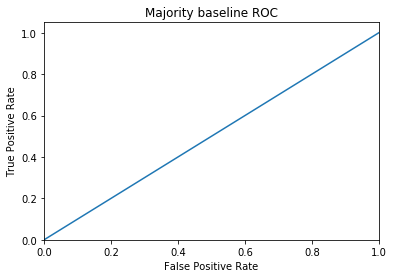

<Figure size 432x288 with 0 Axes>

In [30]:
from matplotlib.pyplot import savefig
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
print(classification_report(y_test, y_baseline_test))
print("Accuracy: ",accuracy_score(y_test, y_baseline_test))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_baseline_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve",roc_auc_score(y_test, y_baseline_test))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Majority baseline ROC')
plt.show()
savefig('Majority Baseline ROC', format= 'png')

## Fix test set for algorithms

We drop the country variables in the test and re-attach them later.

In [31]:
# save countries to a separate dataframe
test_countries = X_test.iloc[:, 1:31] 

# drop countries in test data
idx = np.r_[1:31]
X_test.drop(X_test.columns[idx], axis=1, inplace=True)
X_test

,d11,qe6_1_Not mentioned,qe6_1_Mentioned,qe6_2_Not mentioned,qe6_2_Mentioned,"qe7_1_Yes, definitely","qe7_1_Yes, to some extent","qe7_1_No, not really","qe7_1_No, definitely not",qe8_1_Not mentioned,...,d60_From time to time,d60_Almost never/never,d61r_Low level (1-4 in d61),d61r_Middel level (5-6 in d61),d61r_High level (7-10 in d61),d63_The working class of society,d63_The middle class of society,d63_The upper class of society,d63_Other (SPONTANEOUS),d63_None (SPONTANEOUS)
661,0.20,0,1,1,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
692,0.38,0,1,0,1,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
308,0.31,0,1,0,1,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
450,0.56,0,1,0,1,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
871,0.66,0,1,0,1,1,0,0,0,1,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27415,0.69,1,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
27013,0.44,0,1,0,1,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
26834,0.47,0,1,0,1,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,0
27777,0.42,0,1,1,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0


              precision    recall  f1-score   support

         0.0       0.44      0.50      0.46      1661
         1.0       0.69      0.64      0.66      2914

    accuracy                           0.59      4575
   macro avg       0.56      0.57      0.56      4575
weighted avg       0.60      0.59      0.59      4575

Accuracy:  0.5860109289617487
Area under the curve:  0.5665480891723693


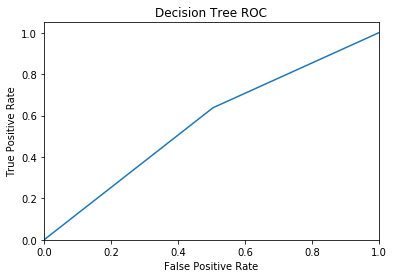

<Figure size 432x288 with 0 Axes>

In [32]:
# Check the Decision Tree baseline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix as confusion_matrix
tree = DecisionTreeClassifier(random_state=3896127045)
tree.fit(X_train_res,y_train_res)
tree_pred = tree.predict(X_test)
print(classification_report(y_test, tree_pred))
print("Accuracy: ", accuracy_score(y_test, tree_pred))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, tree_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve: ",roc_auc_score(y_test, tree_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.show()
savefig('Decision Tree ROC', format= 'png')

The majority-class baseline has a higher f1 and auc scores and hence is selected as the baseline.

### Apply SVM and Random Forest

We will not place the algorithms in one grid (as is demanded by efficiency). There is need to evaluate the performance of the best of each classifier's grid.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.2min
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]:

Best Parameters:  {'classifier': SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 0.1, 'classifier__gamma': 0.01, 'classifier__kernel': 'linear'}
Best Estimator:  Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
              precision    recall  f1-score   support

         0.0       0.62      0.41      0.50      1661
         1.0       0.72      0.86      0.78      2914

    accuracy                       

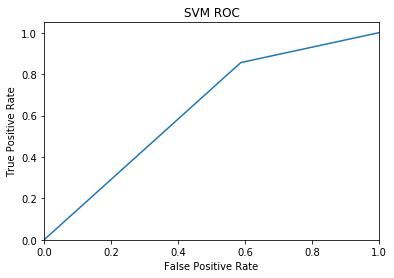

<Figure size 432x288 with 0 Axes>

In [33]:
#SVM

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , svm.SVC(gamma= 'auto'))])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [svm.SVC()],
     'classifier__C' :  [0.1, 0.25, 0.5, 1],
    'classifier__gamma' : [0.01, 0.1, 1, 5, 10],
    'classifier__kernel': ['linear']}
]

# Create grid search object

svm_select = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


# Fit on data, and find best parameter and estimator

best_svm_select = svm_select.fit(X_train_res, y_train_res)

print("Best Parameters: ",best_svm_select.best_params_)
print("Best Estimator: ",best_svm_select.best_estimator_)
# Predict test values

svm_pred = best_svm_select.predict(X_test)

#Evaluate SVM Classifier performance

print(classification_report(y_test, svm_pred))
print(accuracy_score(y_test, svm_pred))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, svm_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve: ",roc_auc_score(y_test, svm_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.show()
savefig('SVM ROC', format= 'png')

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed: 55.9min finished


Best Parameters:  {'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__max_features': 1, 'classifier__n_estimators': 500}
Best Estimator:  Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=1,
                                        max_leaf_nodes=None, max_sampl

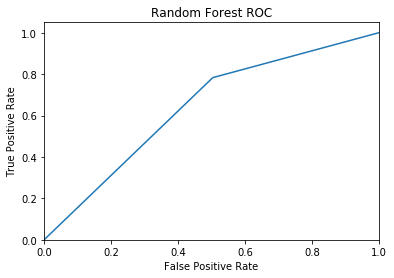

<Figure size 432x288 with 0 Axes>

In [34]:
# Random Forest

# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier(random_state = 3896127045, criterion='entropy'))])

# Create param grid.

param_grid = [{'classifier' : [RandomForestClassifier()],
               'classifier__n_estimators' : list(range(50,600,50)),
               'classifier__max_features' : list(range(1,10,1))}]

# Create grid search object

rf_select = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs = -1)


# Fit on data

best_rf_select = rf_select.fit(X_train_res, y_train_res)
print("Best Parameters: ",best_rf_select.best_params_)
print("Best Estimator: ",best_rf_select.best_estimator_)

# Predict test values

rf_pred = best_rf_select.predict(X_test)

#Evaluate rf Classifier performance

print(classification_report(y_test, rf_pred))
print("Accuracy: ",accuracy_score(y_test, rf_pred))
print(roc_auc_score(y_test, rf_pred))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, rf_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve: ",roc_auc_score(y_test, rf_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.show()
savefig('Random Forest ROC', format= 'png')

In [35]:
#Check validation curves in order to see whether classsifier can be improved
rf_base = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

In [36]:
from sklearn.model_selection import validation_curve
depth = [5,10,15,20, 25,30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
train_scoreNum, test_scoreNum = validation_curve(
                                rf_base,
                                X = X_train_res, y = y_train_res, 
                                param_name = 'max_depth', 
                                param_range = depth, cv = 5)
print(train_scoreNum, test_scoreNum)


[[0.69813779 0.69303437 0.69846354 0.68217601 0.682519  ]
 [0.76035615 0.76220207 0.7633422  0.73402465 0.73946797]
 [0.90683533 0.91215593 0.90726967 0.88571584 0.88572204]
 [0.99120473 0.99120473 0.98952169 0.98713285 0.98789359]
 [0.99956567 0.99972854 0.99961996 0.99961996 0.99945711]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]] [[0.66036916 0.69598263 0.64820847 0.66818675 0.64682884]
 [0.67057546 0.6970684  0.65754615 0.69815418 0.6874457 ]
 [0.68751357 

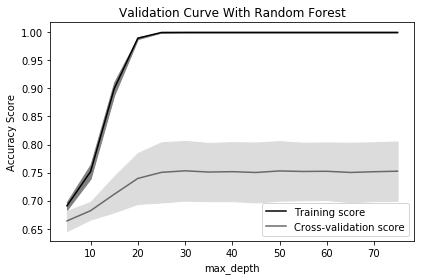

In [37]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(depth, train_mean, label="Training score", color="black")
plt.plot(depth, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(depth, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(depth, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("max_depth")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [38]:
min_samples = [2, 5,10,15,20]
train_scoreNum, test_scoreNum = validation_curve(
                                rf_base,
                                X = X_train_res, y = y_train_res, 
                                param_name = 'min_samples_split', 
                                param_range = min_samples, cv = 5)

print(train_scoreNum, test_scoreNum)

[[0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.97269124 0.97247408 0.96889082 0.95537217 0.95380022]
 [0.89896303 0.90270916 0.89689994 0.86714805 0.86368078]
 [0.85976437 0.86139313 0.8569412  0.8220316  0.81986971]
 [0.83397579 0.83392149 0.83120691 0.79417992 0.79690554]] [[0.71422367 0.71791531 0.69815418 0.82605863 0.80668983]
 [0.69381107 0.70749186 0.68338762 0.80651466 0.78996525]
 [0.68382193 0.69945711 0.67318132 0.77915309 0.76259774]
 [0.67600434 0.69533116 0.66927253 0.76373507 0.75152042]
 [0.67557003 0.69619978 0.66514658 0.75352877 0.74261512]]


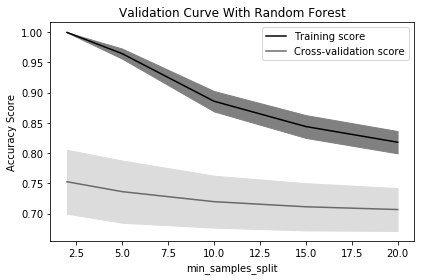

In [39]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(min_samples, train_mean, label="Training score", color="black")
plt.plot(min_samples, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(min_samples, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(min_samples, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [40]:
min_leaf = [1,2,3,4,5,6,7,8,9,10]
train_scoreNum, test_scoreNum = validation_curve(
                               rf_base,
                                X = X_train_res, y = y_train_res, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_leaf, cv = 5)

print(train_scoreNum, test_scoreNum)

[[0.99978283 0.99983712 0.99983712 0.99972854 0.99961998]
 [0.87816928 0.88061241 0.87518323 0.84233672 0.84261672]
 [0.81209621 0.81394212 0.81247625 0.7771866  0.77888165]
 [0.78201857 0.78305011 0.78239861 0.74933493 0.75461455]
 [0.76350508 0.7646452  0.76578533 0.73635919 0.73854506]
 [0.75324393 0.7560671  0.75508985 0.72425213 0.72947883]
 [0.74710896 0.74879201 0.74439438 0.71724849 0.72361564]
 [0.74178837 0.73853086 0.73853086 0.71637983 0.71758958]
 [0.73625061 0.73473044 0.73663065 0.71279657 0.71389794]
 [0.73483902 0.73272165 0.73060427 0.70639014 0.7116721 ]] [[0.71487514 0.71378936 0.69967427 0.82714441 0.80560382]
 [0.68599349 0.70206298 0.67361564 0.75613464 0.74478714]
 [0.67448426 0.69663409 0.66145494 0.73072747 0.71546481]
 [0.669924   0.6970684  0.65993485 0.71813246 0.70482189]
 [0.6723127  0.69598263 0.65732899 0.71465798 0.69830582]
 [0.66558089 0.70162866 0.65450597 0.70380022 0.69287576]
 [0.66644951 0.69576547 0.65646037 0.69815418 0.68961772]
 [0.66319218 

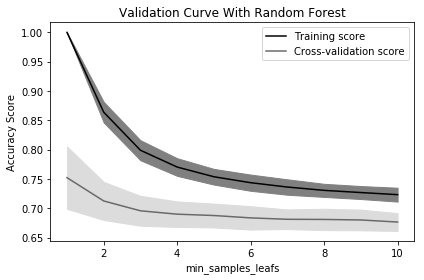

In [41]:
# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(min_leaf, train_mean, label="Training score", color="black")
plt.plot(min_leaf, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(min_leaf, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(min_leaf, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("min_samples_leafs")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

              precision    recall  f1-score   support

         0.0       0.56      0.50      0.53      1661
         1.0       0.73      0.78      0.75      2914

    accuracy                           0.68      4575
   macro avg       0.65      0.64      0.64      4575
weighted avg       0.67      0.68      0.67      4575

Accuracy:  0.6780327868852459
0.6403388197978824
Area under the curve:  0.6403388197978824


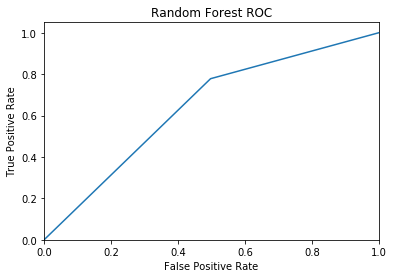

<Figure size 432x288 with 0 Axes>

In [42]:
rf_refined = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Fit on data

best_rf_select = rf_refined.fit(X_train_res, y_train_res)
#predict
rf_pred = best_rf_select.predict(X_test)

#Evaluate rf Classifier performance

print(classification_report(y_test, rf_pred))
print("Accuracy: ",accuracy_score(y_test, rf_pred))
print(roc_auc_score(y_test, rf_pred))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, rf_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve: ",roc_auc_score(y_test, rf_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.show()
savefig('Random Forest ROC', format= 'png')

We now need to see how our classifiers are performing with regards to the baseline and each other. We make use of the McNemar's test. We now need a simple view of this test.

So how does Mcnemar's test work? <img src="mcnemar_contingency_table.png">

The following formula is used to calculate the test statistic, which is expected to follow the chi-squared distribtion under the null hypothesis. This is precisely the same reasoning in conventional statistics for surveys with lots of nominal data.
\begin{align}
\chi^{2} & = \frac{(b-c)^{2}}{(b + c)} \\
\end{align}

We are now ready to perform the tests. The test will be reused later to test for significant differences between models.  

Credits to [Sebastian Raschka](http://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar/) for the picture

In [43]:
# Test for statistical significance in the difference between the baseline and the classifiers

from mlxtend.evaluate import mcnemar_table #kindly ensure mlxtend is installed on your Anaconda prompt
from mlxtend.evaluate import mcnemar

# Setting baseline to numpy array to support McNemar's test

y_baseline_test1 = np.array(y_baseline_test)

#Perform the test

tb = mcnemar_table(y_target= y_test, 
                   y_model1=y_baseline_test1, 
                   y_model2= svm_pred)

tb2 = mcnemar_table(y_target= y_test, 
                   y_model1=y_baseline_test1, 
                   y_model2=rf_pred)

tb_chi2, tb_p = mcnemar(ary=tb, corrected=True)
tb2_chi2, tb2_p = mcnemar(ary=tb2, corrected=True)
print("'McNemar's table and test: Baseline-SVM \n",tb)
print('chi-squared:', tb_chi2)
print('p-value:', tb_p)

print("'McNemar's table and test: Baseline-Random Forest \n",tb2)
print('chi-squared:', tb2_chi2)
print('p-value:', tb2_p)



'McNemar's table and test: Baseline-SVM 
 [[2494  685]
 [ 420  976]]
chi-squared: 63.07330316742082
p-value: 1.9915520109612296e-15
'McNemar's table and test: Baseline-Random Forest 
 [[2267  835]
 [ 647  826]]
chi-squared: 23.595816464237515
p-value: 1.1884562110563559e-06


All algorithms yield predictions which are significantly different from the majority baseline. which is a good sign and lends us to the conclusion that machine learning can indeed be ued to prediction blood donation willingness.

We now move to select the better performing algorithm.

In [44]:
# Test for statistical significance in the difference between the classifiers
## Random forest/SVM

tb4 = mcnemar_table(y_target= y_test, 
                   y_model1=svm_pred, 
                   y_model2=rf_pred)
tb4_chi2, tb4_p = mcnemar(ary=tb4, corrected=True)
print("'McNemar's table and test: RF-SVM \n",tb4)
print('chi-squared:', tb4_chi2)
print('p-value:', tb4_p)


'McNemar's table and test: RF-SVM 
 [[2798  304]
 [ 381 1092]]
chi-squared: 8.432116788321167
p-value: 0.0036865094127833844


The predictions from the Random Forest and Support Vector Machine Classifiers are not significantly different from each other. This justifies using either of the two classifiers for the next phase.

We select the SVM Classifier for its higher f1-score. 

Since the p-value is larger than our assumed significance threshold (α=0.05), we cannot reject our null hypothesis and assume that there is no significant difference between the two predictive models.

http://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar/

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

### Country level metrics

In [45]:
# Wrangle the test set inorder to include the target values, their baseline prediction and the classifier's predictions

Test_Pred_set = X_test
Test_Pred_set['svm_pred'] = svm_pred
Test_Pred_set['y_test'] = y_test
Test_Pred_set['y_baseline_test']= y_baseline_test
Test_Pred_set['rf_pred']=rf_pred
#Test_Pred_set = pd.concat(test_countries, Test_Pred_set, axis=1, sort=False)
#Test_Pred_set = test_countries + Test_Pred_set

In [46]:
Test_Pred_set['tnscntry_BELGIQUE'] = test_countries['tnscntry_BELGIQUE']
Test_Pred_set['tnscntry_DANMARK'] = test_countries['tnscntry_DANMARK']
Test_Pred_set['tnscntry_ELLADA'] = test_countries['tnscntry_ELLADA']
Test_Pred_set['tnscntry_ESPANA'] = test_countries['tnscntry_ESPANA']
Test_Pred_set['tnscntry_SUOMI'] = test_countries['tnscntry_SUOMI']
Test_Pred_set['tnscntry_FRANCE'] = test_countries['tnscntry_FRANCE']
Test_Pred_set['tnscntry_IRELAND'] = test_countries['tnscntry_IRELAND']
Test_Pred_set['tnscntry_ITALIA'] = test_countries['tnscntry_ITALIA']
Test_Pred_set['tnscntry_LUXEMBOURG'] = test_countries['tnscntry_LUXEMBOURG']
Test_Pred_set['tnscntry_NEDERLAND'] = test_countries['tnscntry_NEDERLAND']
Test_Pred_set['tnscntry_ÖSTERREICH'] = test_countries['tnscntry_ÖSTERREICH']
Test_Pred_set['tnscntry_PORTUGAL'] = test_countries['tnscntry_PORTUGAL']
Test_Pred_set['tnscntry_SVERIGE'] = test_countries['tnscntry_SVERIGE']
Test_Pred_set['tnscntry_DEUTSCHLAND WEST'] = test_countries['tnscntry_DEUTSCHLAND WEST']
Test_Pred_set['tnscntry_DEUTSCHLAND OST'] = test_countries['tnscntry_DEUTSCHLAND OST']
Test_Pred_set['tnscntry_GREAT BRITAIN'] = test_countries['tnscntry_GREAT BRITAIN']
Test_Pred_set['tnscntry_NORTHERN IRELAND'] = test_countries['tnscntry_NORTHERN IRELAND']
Test_Pred_set['tnscntry_BALGARIJA'] = test_countries['tnscntry_BALGARIJA']
Test_Pred_set['tnscntry_KYPROS'] = test_countries['tnscntry_KYPROS']
Test_Pred_set['tnscntry_CESKA REPUBLIKA'] = test_countries['tnscntry_CESKA REPUBLIKA']
Test_Pred_set['tnscntry_EESTI'] = test_countries['tnscntry_EESTI']
Test_Pred_set['tnscntry_MAGYARORSZAG'] = test_countries['tnscntry_MAGYARORSZAG']
Test_Pred_set['tnscntry_LATVIA'] = test_countries['tnscntry_LATVIA']
Test_Pred_set['tnscntry_LIETUVA'] = test_countries['tnscntry_LIETUVA']
Test_Pred_set['tnscntry_MALTA'] = test_countries['tnscntry_MALTA']
Test_Pred_set['tnscntry_POLSKA'] = test_countries['tnscntry_POLSKA']
Test_Pred_set['tnscntry_ROMANIA'] = test_countries['tnscntry_ROMANIA']
Test_Pred_set['tnscntry_SLOVENSKA REPUBLIC'] = test_countries['tnscntry_SLOVENSKA REPUBLIC']
Test_Pred_set['tnscntry_SLOVENIJA'] = test_countries['tnscntry_SLOVENIJA']
Test_Pred_set['tnscntry_HRVATSKA'] = test_countries['tnscntry_HRVATSKA']


In [47]:
Test_Pred_set

,d11,qe6_1_Not mentioned,qe6_1_Mentioned,qe6_2_Not mentioned,qe6_2_Mentioned,"qe7_1_Yes, definitely","qe7_1_Yes, to some extent","qe7_1_No, not really","qe7_1_No, definitely not",qe8_1_Not mentioned,...,tnscntry_EESTI,tnscntry_MAGYARORSZAG,tnscntry_LATVIA,tnscntry_LIETUVA,tnscntry_MALTA,tnscntry_POLSKA,tnscntry_ROMANIA,tnscntry_SLOVENSKA REPUBLIC,tnscntry_SLOVENIJA,tnscntry_HRVATSKA
661,0.20,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
692,0.38,0,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
308,0.31,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
450,0.56,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
871,0.66,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27415,0.69,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
27013,0.44,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
26834,0.47,0,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
27777,0.42,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [48]:

# Create lists of the required metrics per country

#BELGIQUE

BELGIQUE_test = Test_Pred_set[Test_Pred_set.tnscntry_BELGIQUE == 1]
BELGIQUE_y_baseline = BELGIQUE_test.pop('y_baseline_test')
BELGIQUE_y_actual = BELGIQUE_test.pop('y_test')
BELGIQUE_y_pred = BELGIQUE_test.pop('svm_pred')
a = accuracy_score(BELGIQUE_y_actual, BELGIQUE_y_baseline)

b = precision_score(BELGIQUE_y_actual, BELGIQUE_y_baseline)

c = recall_score(BELGIQUE_y_actual, BELGIQUE_y_baseline)

d = f1_score(BELGIQUE_y_actual, BELGIQUE_y_baseline)

e = accuracy_score(BELGIQUE_y_actual, BELGIQUE_y_pred)

f = precision_score(BELGIQUE_y_actual, BELGIQUE_y_pred)

g = recall_score(BELGIQUE_y_actual, BELGIQUE_y_pred)

h = f1_score(BELGIQUE_y_actual, BELGIQUE_y_pred)


#Creating list of metrics
BELGIQUE_results = ['BELGIQUE', a, e, b, f, c, g, d, h]

#DANMARK

DANMARK_test = Test_Pred_set[Test_Pred_set.tnscntry_DANMARK == 1]
DANMARK_y_baseline = DANMARK_test.pop('y_baseline_test')
DANMARK_y_actual = DANMARK_test.pop('y_test')
DANMARK_y_pred = DANMARK_test.pop('svm_pred')
a = accuracy_score(DANMARK_y_actual, DANMARK_y_baseline)

b = precision_score(DANMARK_y_actual, DANMARK_y_baseline)

c = recall_score(DANMARK_y_actual, DANMARK_y_baseline)

d = f1_score(DANMARK_y_actual, DANMARK_y_baseline)

e = accuracy_score(DANMARK_y_actual, DANMARK_y_pred)

f = precision_score(DANMARK_y_actual, DANMARK_y_pred)

g = recall_score(DANMARK_y_actual, DANMARK_y_pred)

h = f1_score(DANMARK_y_actual, DANMARK_y_pred)


#Creating list of metrics
DANMARK_results = ['DANMARK', a, e, b, f, c, g, d, h]


#ELLADA

ELLADA_test = Test_Pred_set[Test_Pred_set.tnscntry_ELLADA == 1]
ELLADA_y_baseline = ELLADA_test.pop('y_baseline_test')
ELLADA_y_actual = ELLADA_test.pop('y_test')
ELLADA_y_pred = ELLADA_test.pop('svm_pred')
a = accuracy_score(ELLADA_y_actual, ELLADA_y_baseline)

b = precision_score(ELLADA_y_actual, ELLADA_y_baseline)

c = recall_score(ELLADA_y_actual, ELLADA_y_baseline)

d = f1_score(ELLADA_y_actual, ELLADA_y_baseline)

e = accuracy_score(ELLADA_y_actual, ELLADA_y_pred)

f = precision_score(ELLADA_y_actual, ELLADA_y_pred)

g = recall_score(ELLADA_y_actual, ELLADA_y_pred)

h = f1_score(ELLADA_y_actual, ELLADA_y_pred)


#Creating list of metrics
ELLADA_results = ['ELLADA', a, e, b, f, c, g, d, h]


#ESPANA

ESPANA_test = Test_Pred_set[Test_Pred_set.tnscntry_ESPANA == 1]
ESPANA_y_baseline = ESPANA_test.pop('y_baseline_test')
ESPANA_y_actual = ESPANA_test.pop('y_test')
ESPANA_y_pred = ESPANA_test.pop('svm_pred')
a = accuracy_score(ESPANA_y_actual, ESPANA_y_baseline)

b = precision_score(ESPANA_y_actual, ESPANA_y_baseline)

c = recall_score(ESPANA_y_actual, ESPANA_y_baseline)

d = f1_score(ESPANA_y_actual, ESPANA_y_baseline)

e = accuracy_score(ESPANA_y_actual, ESPANA_y_pred)

f = precision_score(ESPANA_y_actual, ESPANA_y_pred)

g = recall_score(ESPANA_y_actual, ESPANA_y_pred)

h = f1_score(ESPANA_y_actual, ESPANA_y_pred)


#Creating list of metrics
ESPANA_results = ['ESPANA', a, e, b, f, c, g, d, h]


#Finland

#SUOMI

SUOMI_test = Test_Pred_set[Test_Pred_set.tnscntry_SUOMI == 1]
SUOMI_y_baseline = SUOMI_test.pop('y_baseline_test')
SUOMI_y_actual = SUOMI_test.pop('y_test')
SUOMI_y_pred = SUOMI_test.pop('svm_pred')
a = accuracy_score(SUOMI_y_actual, SUOMI_y_baseline)

b = precision_score(SUOMI_y_actual, SUOMI_y_baseline)

c = recall_score(SUOMI_y_actual, SUOMI_y_baseline)

d = f1_score(SUOMI_y_actual, SUOMI_y_baseline)

e = accuracy_score(SUOMI_y_actual, SUOMI_y_pred)

f = precision_score(SUOMI_y_actual, SUOMI_y_pred)

g = recall_score(SUOMI_y_actual, SUOMI_y_pred)

h = f1_score(SUOMI_y_actual, SUOMI_y_pred)


#Creating list of metrics
SUOMI_results = ['SUOMI', a, e, b, f, c, g, d, h]



#France

FRANCE_test = Test_Pred_set[Test_Pred_set.tnscntry_FRANCE == 1]
FRANCE_y_baseline = FRANCE_test.pop('y_baseline_test')
FRANCE_y_actual = FRANCE_test.pop('y_test')
FRANCE_y_pred = FRANCE_test.pop('svm_pred')
a = accuracy_score(FRANCE_y_actual, FRANCE_y_baseline)

b = precision_score(FRANCE_y_actual, FRANCE_y_baseline)

c = recall_score(FRANCE_y_actual, FRANCE_y_baseline)

d = f1_score(FRANCE_y_actual, FRANCE_y_baseline)

e = accuracy_score(FRANCE_y_actual, FRANCE_y_pred)

f = precision_score(FRANCE_y_actual, FRANCE_y_pred)

g = recall_score(FRANCE_y_actual, FRANCE_y_pred)

h = f1_score(FRANCE_y_actual, FRANCE_y_pred)


#Creating list of metrics
FRANCE_results = ['FRANCE', a, e, b, f, c, g, d, h]

#IRELAND

IRELAND_test = Test_Pred_set[Test_Pred_set.tnscntry_IRELAND == 1]
IRELAND_y_baseline = IRELAND_test.pop('y_baseline_test')
IRELAND_y_actual = IRELAND_test.pop('y_test')
IRELAND_y_pred = IRELAND_test.pop('svm_pred')
a = accuracy_score(IRELAND_y_actual, IRELAND_y_baseline)

b = precision_score(IRELAND_y_actual, IRELAND_y_baseline)

c = recall_score(IRELAND_y_actual, IRELAND_y_baseline)

d = f1_score(IRELAND_y_actual, IRELAND_y_baseline)

e = accuracy_score(IRELAND_y_actual, IRELAND_y_pred)

f = precision_score(IRELAND_y_actual, IRELAND_y_pred)

g = recall_score(IRELAND_y_actual, IRELAND_y_pred)

h = f1_score(IRELAND_y_actual, IRELAND_y_pred)


#Creating list of metrics
IRELAND_results = ['IRELAND', a, e, b, f, c, g, d, h]

#ITALIA

ITALIA_test = Test_Pred_set[Test_Pred_set.tnscntry_ITALIA == 1]
ITALIA_y_baseline = ITALIA_test.pop('y_baseline_test')
ITALIA_y_actual = ITALIA_test.pop('y_test')
ITALIA_y_pred = ITALIA_test.pop('svm_pred')
a = accuracy_score(ITALIA_y_actual, ITALIA_y_baseline)

b = precision_score(ITALIA_y_actual, ITALIA_y_baseline)

c = recall_score(ITALIA_y_actual, ITALIA_y_baseline)

d = f1_score(ITALIA_y_actual, ITALIA_y_baseline)

e = accuracy_score(ITALIA_y_actual, ITALIA_y_pred)

f = precision_score(ITALIA_y_actual, ITALIA_y_pred)

g = recall_score(ITALIA_y_actual, ITALIA_y_pred)

h = f1_score(ITALIA_y_actual, ITALIA_y_pred)


#Creating list of metrics
ITALIA_results = ['ITALIA', a, e, b, f, c, g, d, h]


#LUXEMBOURG

LUXEMBOURG_test = Test_Pred_set[Test_Pred_set.tnscntry_LUXEMBOURG == 1]
LUXEMBOURG_y_baseline = LUXEMBOURG_test.pop('y_baseline_test')
LUXEMBOURG_y_actual = LUXEMBOURG_test.pop('y_test')
LUXEMBOURG_y_pred = LUXEMBOURG_test.pop('svm_pred')
a = accuracy_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_baseline)

b = precision_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_baseline)

c = recall_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_baseline)

d = f1_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_baseline)

e = accuracy_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_pred)

f = precision_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_pred)

g = recall_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_pred)

h = f1_score(LUXEMBOURG_y_actual, LUXEMBOURG_y_pred)


#Creating list of metrics
LUXEMBOURG_results = ['LUXEMBOURG', a, e, b, f, c, g, d, h]


#NEDERLAND

NEDERLAND_test = Test_Pred_set[Test_Pred_set.tnscntry_NEDERLAND == 1]
NEDERLAND_y_baseline = NEDERLAND_test.pop('y_baseline_test')
NEDERLAND_y_actual = NEDERLAND_test.pop('y_test')
NEDERLAND_y_pred = NEDERLAND_test.pop('svm_pred')
a = accuracy_score(NEDERLAND_y_actual, NEDERLAND_y_baseline)

b = precision_score(NEDERLAND_y_actual, NEDERLAND_y_baseline)

c = recall_score(NEDERLAND_y_actual, NEDERLAND_y_baseline)

d = f1_score(NEDERLAND_y_actual, NEDERLAND_y_baseline)

e = accuracy_score(NEDERLAND_y_actual, NEDERLAND_y_pred)

f = precision_score(NEDERLAND_y_actual, NEDERLAND_y_pred)

g = recall_score(NEDERLAND_y_actual, NEDERLAND_y_pred)

h = f1_score(NEDERLAND_y_actual, NEDERLAND_y_pred)


#Creating list of metrics
NEDERLAND_results = ['NEDERLAND', a, e, b, f, c, g, d, h]


#ÖSTERREICH

ÖSTERREICH_test = Test_Pred_set[Test_Pred_set.tnscntry_ÖSTERREICH == 1]
ÖSTERREICH_y_baseline = ÖSTERREICH_test.pop('y_baseline_test')
ÖSTERREICH_y_actual = ÖSTERREICH_test.pop('y_test')
ÖSTERREICH_y_pred = ÖSTERREICH_test.pop('svm_pred')
a = accuracy_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_baseline)

b = precision_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_baseline)

c = recall_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_baseline)

d = f1_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_baseline)

e = accuracy_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_pred)

f = precision_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_pred)

g = recall_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_pred)

h = f1_score(ÖSTERREICH_y_actual, ÖSTERREICH_y_pred)


#Creating list of metrics
ÖSTERREICH_results = ['ÖSTERREICH', a, e, b, f, c, g, d, h]


#PORTUGAL

PORTUGAL_test = Test_Pred_set[Test_Pred_set.tnscntry_PORTUGAL == 1]
PORTUGAL_y_baseline = PORTUGAL_test.pop('y_baseline_test')
PORTUGAL_y_actual = PORTUGAL_test.pop('y_test')
PORTUGAL_y_pred = PORTUGAL_test.pop('svm_pred')
a = accuracy_score(PORTUGAL_y_actual, PORTUGAL_y_baseline)

b = precision_score(PORTUGAL_y_actual, PORTUGAL_y_baseline)

c = recall_score(PORTUGAL_y_actual, PORTUGAL_y_baseline)

d = f1_score(PORTUGAL_y_actual, PORTUGAL_y_baseline)

e = accuracy_score(PORTUGAL_y_actual, PORTUGAL_y_pred)

f = precision_score(PORTUGAL_y_actual, PORTUGAL_y_pred)

g = recall_score(PORTUGAL_y_actual, PORTUGAL_y_pred)

h = f1_score(PORTUGAL_y_actual, PORTUGAL_y_pred)


#Creating list of metrics
PORTUGAL_results = ['PORTUGAL', a, e, b, f, c, g, d, h]


#SVERIGE

SVERIGE_test = Test_Pred_set[Test_Pred_set.tnscntry_SVERIGE == 1]
SVERIGE_y_baseline = SVERIGE_test.pop('y_baseline_test')
SVERIGE_y_actual = SVERIGE_test.pop('y_test')
SVERIGE_y_pred = SVERIGE_test.pop('svm_pred')
a = accuracy_score(SVERIGE_y_actual, SVERIGE_y_baseline)

b = precision_score(SVERIGE_y_actual, SVERIGE_y_baseline)

c = recall_score(SVERIGE_y_actual, SVERIGE_y_baseline)

d = f1_score(SVERIGE_y_actual, SVERIGE_y_baseline)

e = accuracy_score(SVERIGE_y_actual, SVERIGE_y_pred)

f = precision_score(SVERIGE_y_actual, SVERIGE_y_pred)

g = recall_score(SVERIGE_y_actual, SVERIGE_y_pred)

h = f1_score(SVERIGE_y_actual, SVERIGE_y_pred)


#Creating list of metrics
SVERIGE_results = ['SVERIGE', a, e, b, f, c, g, d, h]

#DEUTSCHLAND_WEST

DEUTSCHLAND_WEST_test = Test_Pred_set[Test_Pred_set['tnscntry_DEUTSCHLAND WEST'] == 1]
DEUTSCHLAND_WEST_y_baseline = DEUTSCHLAND_WEST_test.pop('y_baseline_test')
DEUTSCHLAND_WEST_y_actual = DEUTSCHLAND_WEST_test.pop('y_test')
DEUTSCHLAND_WEST_y_pred = DEUTSCHLAND_WEST_test.pop('svm_pred')
a = accuracy_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_baseline)

b = precision_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_baseline)

c = recall_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_baseline)

d = f1_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_baseline)

e = accuracy_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_pred)

f = precision_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_pred)

g = recall_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_pred)

h = f1_score(DEUTSCHLAND_WEST_y_actual, DEUTSCHLAND_WEST_y_pred)


#Creating list of metrics
DEUTSCHLAND_WEST_results = ['DEUTSCHLAND_WEST', a, e, b, f, c, g, d, h]
DEUTSCHLAND_WEST_results

DEUTSCHLAND_OST_test = Test_Pred_set[Test_Pred_set['tnscntry_DEUTSCHLAND OST'] == 1]
DEUTSCHLAND_OST_y_baseline = DEUTSCHLAND_OST_test.pop('y_baseline_test')
DEUTSCHLAND_OST_y_actual = DEUTSCHLAND_OST_test.pop('y_test')
DEUTSCHLAND_OST_y_pred = DEUTSCHLAND_OST_test.pop('svm_pred')
a = accuracy_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_baseline)

b = precision_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_baseline)

c = recall_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_baseline)

d = f1_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_baseline)

e = accuracy_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_pred)

f = precision_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_pred)

g = recall_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_pred)

h = f1_score(DEUTSCHLAND_OST_y_actual, DEUTSCHLAND_OST_y_pred)


#Creating list of metrics
DEUTSCHLAND_OST_results = ['DEUTSCHLAND_OST', a, e, b, f, c, g, d, h]

#Great Britain

GREAT_BRITAIN_test = Test_Pred_set[Test_Pred_set['tnscntry_GREAT BRITAIN'] == 1]
GREAT_BRITAIN_y_baseline = GREAT_BRITAIN_test.pop('y_baseline_test')
GREAT_BRITAIN_y_actual = GREAT_BRITAIN_test.pop('y_test')
GREAT_BRITAIN_y_pred = GREAT_BRITAIN_test.pop('svm_pred')
a = accuracy_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_baseline)

b = precision_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_baseline)

c = recall_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_baseline)

d = f1_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_baseline)

e = accuracy_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_pred)

f = precision_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_pred)

g = recall_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_pred)

h = f1_score(GREAT_BRITAIN_y_actual, GREAT_BRITAIN_y_pred)


#Creating list of metrics
GREAT_BRITAIN_results = ['GREAT_BRITAIN', a, e, b, f, c, g, d, h]

#Northern Ireland

NORTHERN_IRELAND_test = Test_Pred_set[Test_Pred_set['tnscntry_NORTHERN IRELAND'] == 1]
NORTHERN_IRELAND_y_baseline = NORTHERN_IRELAND_test.pop('y_baseline_test')
NORTHERN_IRELAND_y_actual = NORTHERN_IRELAND_test.pop('y_test')
NORTHERN_IRELAND_y_pred = NORTHERN_IRELAND_test.pop('svm_pred')
a = accuracy_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_baseline)

b = precision_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_baseline)

c = recall_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_baseline)

d = f1_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_baseline)

e = accuracy_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_pred)

f = precision_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_pred)

g = recall_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_pred)

h = f1_score(NORTHERN_IRELAND_y_actual, NORTHERN_IRELAND_y_pred)


#Creating list of metrics
NORTHERN_IRELAND_results = ['NORTHERN_IRELAND', a, e, b, f, c, g, d, h]

#BALGARIJA

BALGARIJA_test = Test_Pred_set[Test_Pred_set.tnscntry_BALGARIJA == 1]
BALGARIJA_y_baseline = BALGARIJA_test.pop('y_baseline_test')
BALGARIJA_y_actual = BALGARIJA_test.pop('y_test')
BALGARIJA_y_pred = BALGARIJA_test.pop('svm_pred')
a = accuracy_score(BALGARIJA_y_actual, BALGARIJA_y_baseline)

b = precision_score(BALGARIJA_y_actual, BALGARIJA_y_baseline)

c = recall_score(BALGARIJA_y_actual, BALGARIJA_y_baseline)

d = f1_score(BALGARIJA_y_actual, BALGARIJA_y_baseline)

e = accuracy_score(BALGARIJA_y_actual, BALGARIJA_y_pred)

f = precision_score(BALGARIJA_y_actual, BALGARIJA_y_pred)

g = recall_score(BALGARIJA_y_actual, BALGARIJA_y_pred)

h = f1_score(BALGARIJA_y_actual, BALGARIJA_y_pred)


#Creating list of metrics
BALGARIJA_results = ['BALGARIJA', a, e, b, f, c, g, d, h]

#KYPROS

KYPROS_test = Test_Pred_set[Test_Pred_set.tnscntry_KYPROS == 1]
KYPROS_y_baseline = KYPROS_test.pop('y_baseline_test')
KYPROS_y_actual = KYPROS_test.pop('y_test')
KYPROS_y_pred = KYPROS_test.pop('svm_pred')
a = accuracy_score(KYPROS_y_actual, KYPROS_y_baseline)

b = precision_score(KYPROS_y_actual, KYPROS_y_baseline)

c = recall_score(KYPROS_y_actual, KYPROS_y_baseline)

d = f1_score(KYPROS_y_actual, KYPROS_y_baseline)

e = accuracy_score(KYPROS_y_actual, KYPROS_y_pred)

f = precision_score(KYPROS_y_actual, KYPROS_y_pred)

g = recall_score(KYPROS_y_actual, KYPROS_y_pred)

h = f1_score(KYPROS_y_actual, KYPROS_y_pred)


#Creating list of metrics
KYPROS_results = ['KYPROS', a, e, b, f, c, g, d, h]

#EESTI

EESTI_test = Test_Pred_set[Test_Pred_set.tnscntry_EESTI == 1]
EESTI_y_baseline = EESTI_test.pop('y_baseline_test')
EESTI_y_actual = EESTI_test.pop('y_test')
EESTI_y_pred = EESTI_test.pop('svm_pred')
a = accuracy_score(EESTI_y_actual, EESTI_y_baseline)

b = precision_score(EESTI_y_actual, EESTI_y_baseline)

c = recall_score(EESTI_y_actual, EESTI_y_baseline)

d = f1_score(EESTI_y_actual, EESTI_y_baseline)

e = accuracy_score(EESTI_y_actual, EESTI_y_pred)

f = precision_score(EESTI_y_actual, EESTI_y_pred)

g = recall_score(EESTI_y_actual, EESTI_y_pred)

h = f1_score(EESTI_y_actual, EESTI_y_pred)


#Creating list of metrics
EESTI_results = ['EESTI', a, e, b, f, c, g, d, h]

#MAGYARORSZAG

MAGYARORSZAG_test = Test_Pred_set[Test_Pred_set.tnscntry_MAGYARORSZAG == 1]
MAGYARORSZAG_y_baseline = MAGYARORSZAG_test.pop('y_baseline_test')
MAGYARORSZAG_y_actual = MAGYARORSZAG_test.pop('y_test')
MAGYARORSZAG_y_pred = MAGYARORSZAG_test.pop('svm_pred')
a = accuracy_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_baseline)

b = precision_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_baseline)

c = recall_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_baseline)

d = f1_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_baseline)

e = accuracy_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_pred)

f = precision_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_pred)

g = recall_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_pred)

h = f1_score(MAGYARORSZAG_y_actual, MAGYARORSZAG_y_pred)


#Creating list of metrics
MAGYARORSZAG_results = ['MAGYARORSZAG', a, e, b, f, c, g, d, h]

#LATVIA

LATVIA_test = Test_Pred_set[Test_Pred_set.tnscntry_LATVIA == 1]
LATVIA_y_baseline = LATVIA_test.pop('y_baseline_test')
LATVIA_y_actual = LATVIA_test.pop('y_test')
LATVIA_y_pred = LATVIA_test.pop('svm_pred')
a = accuracy_score(LATVIA_y_actual, LATVIA_y_baseline)

b = precision_score(LATVIA_y_actual, LATVIA_y_baseline)

c = recall_score(LATVIA_y_actual, LATVIA_y_baseline)

d = f1_score(LATVIA_y_actual, LATVIA_y_baseline)

e = accuracy_score(LATVIA_y_actual, LATVIA_y_pred)

f = precision_score(LATVIA_y_actual, LATVIA_y_pred)

g = recall_score(LATVIA_y_actual, LATVIA_y_pred)

h = f1_score(LATVIA_y_actual, LATVIA_y_pred)


#Creating list of metrics
LATVIA_results = ['LATVIA', a, e, b, f, c, g, d, h]

#LIETUVA

LIETUVA_test = Test_Pred_set[Test_Pred_set.tnscntry_LIETUVA == 1]
LIETUVA_y_baseline = LIETUVA_test.pop('y_baseline_test')
LIETUVA_y_actual = LIETUVA_test.pop('y_test')
LIETUVA_y_pred = LIETUVA_test.pop('svm_pred')
a = accuracy_score(LIETUVA_y_actual, LIETUVA_y_baseline)

b = precision_score(LIETUVA_y_actual, LIETUVA_y_baseline)

c = recall_score(LIETUVA_y_actual, LIETUVA_y_baseline)

d = f1_score(LIETUVA_y_actual, LIETUVA_y_baseline)

e = accuracy_score(LIETUVA_y_actual, LIETUVA_y_pred)

f = precision_score(LIETUVA_y_actual, LIETUVA_y_pred)

g = recall_score(LIETUVA_y_actual, LIETUVA_y_pred)

h = f1_score(LIETUVA_y_actual, LIETUVA_y_pred)


#Creating list of metrics
LIETUVA_results = ['LIETUVA', a, e, b, f, c, g, d, h]

#MALTA

MALTA_test = Test_Pred_set[Test_Pred_set.tnscntry_MALTA == 1]
MALTA_y_baseline = MALTA_test.pop('y_baseline_test')
MALTA_y_actual = MALTA_test.pop('y_test')
MALTA_y_pred = MALTA_test.pop('svm_pred')
a = accuracy_score(MALTA_y_actual, MALTA_y_baseline)

b = precision_score(MALTA_y_actual, MALTA_y_baseline)

c = recall_score(MALTA_y_actual, MALTA_y_baseline)

d = f1_score(MALTA_y_actual, MALTA_y_baseline)

e = accuracy_score(MALTA_y_actual, MALTA_y_pred)

f = precision_score(MALTA_y_actual, MALTA_y_pred)

g = recall_score(MALTA_y_actual, MALTA_y_pred)

h = f1_score(MALTA_y_actual, MALTA_y_pred)


#Creating list of metrics
MALTA_results = ['MALTA', a, e, b, f, c, g, d, h]

#POLSKA

POLSKA_test = Test_Pred_set[Test_Pred_set.tnscntry_POLSKA == 1]
POLSKA_y_baseline = POLSKA_test.pop('y_baseline_test')
POLSKA_y_actual = POLSKA_test.pop('y_test')
POLSKA_y_pred = POLSKA_test.pop('svm_pred')
a = accuracy_score(POLSKA_y_actual, POLSKA_y_baseline)

b = precision_score(POLSKA_y_actual, POLSKA_y_baseline)

c = recall_score(POLSKA_y_actual, POLSKA_y_baseline)

d = f1_score(POLSKA_y_actual, POLSKA_y_baseline)

e = accuracy_score(POLSKA_y_actual, POLSKA_y_pred)

f = precision_score(POLSKA_y_actual, POLSKA_y_pred)

g = recall_score(POLSKA_y_actual, POLSKA_y_pred)

h = f1_score(POLSKA_y_actual, POLSKA_y_pred)


#Creating list of metrics
POLSKA_results = ['POLSKA', a, e, b, f, c, g, d, h]

#ROMANIA

ROMANIA_test = Test_Pred_set[Test_Pred_set.tnscntry_ROMANIA == 1]
ROMANIA_y_baseline = ROMANIA_test.pop('y_baseline_test')
ROMANIA_y_actual = ROMANIA_test.pop('y_test')
ROMANIA_y_pred = ROMANIA_test.pop('svm_pred')
a = accuracy_score(ROMANIA_y_actual, ROMANIA_y_baseline)

b = precision_score(ROMANIA_y_actual, ROMANIA_y_baseline)

c = recall_score(ROMANIA_y_actual, ROMANIA_y_baseline)

d = f1_score(ROMANIA_y_actual, ROMANIA_y_baseline)

e = accuracy_score(ROMANIA_y_actual, ROMANIA_y_pred)

f = precision_score(ROMANIA_y_actual, ROMANIA_y_pred)

g = recall_score(ROMANIA_y_actual, ROMANIA_y_pred)

h = f1_score(ROMANIA_y_actual, ROMANIA_y_pred)


#Creating list of metrics
ROMANIA_results = ['ROMANIA', a, e, b, f, c, g, d, h]

#SLOVENIJA

SLOVENIJA_test = Test_Pred_set[Test_Pred_set.tnscntry_SLOVENIJA == 1]
SLOVENIJA_y_baseline = SLOVENIJA_test.pop('y_baseline_test')
SLOVENIJA_y_actual = SLOVENIJA_test.pop('y_test')
SLOVENIJA_y_pred = SLOVENIJA_test.pop('svm_pred')
a = accuracy_score(SLOVENIJA_y_actual, SLOVENIJA_y_baseline)

b = precision_score(SLOVENIJA_y_actual, SLOVENIJA_y_baseline)

c = recall_score(SLOVENIJA_y_actual, SLOVENIJA_y_baseline)

d = f1_score(SLOVENIJA_y_actual, SLOVENIJA_y_baseline)

e = accuracy_score(SLOVENIJA_y_actual, SLOVENIJA_y_pred)

f = precision_score(SLOVENIJA_y_actual, SLOVENIJA_y_pred)

g = recall_score(SLOVENIJA_y_actual, SLOVENIJA_y_pred)

h = f1_score(SLOVENIJA_y_actual, SLOVENIJA_y_pred)


#Creating list of metrics
SLOVENIJA_results = ['SLOVENIJA', a, e, b, f, c, g, d, h]

#HRVATSKA

HRVATSKA_test = Test_Pred_set[Test_Pred_set.tnscntry_HRVATSKA == 1]
HRVATSKA_y_baseline = HRVATSKA_test.pop('y_baseline_test')
HRVATSKA_y_actual = HRVATSKA_test.pop('y_test')
HRVATSKA_y_pred = HRVATSKA_test.pop('svm_pred')
a = accuracy_score(HRVATSKA_y_actual, HRVATSKA_y_baseline)

b = precision_score(HRVATSKA_y_actual, HRVATSKA_y_baseline)

c = recall_score(HRVATSKA_y_actual, HRVATSKA_y_baseline)

d = f1_score(HRVATSKA_y_actual, HRVATSKA_y_baseline)

e = accuracy_score(HRVATSKA_y_actual, HRVATSKA_y_pred)

f = precision_score(HRVATSKA_y_actual, HRVATSKA_y_pred)

g = recall_score(HRVATSKA_y_actual, HRVATSKA_y_pred)

h = f1_score(HRVATSKA_y_actual, HRVATSKA_y_pred)


#Creating list of metrics
HRVATSKA_results = ['HRVATSKA', a, e, b, f, c, g, d, h]

#CESKA_REPUBLIKA

CESKA_REPUBLIKA_test = Test_Pred_set[Test_Pred_set['tnscntry_CESKA REPUBLIKA'] == 1]
CESKA_REPUBLIKA_y_baseline = CESKA_REPUBLIKA_test.pop('y_baseline_test')
CESKA_REPUBLIKA_y_actual = CESKA_REPUBLIKA_test.pop('y_test')
CESKA_REPUBLIKA_y_pred = CESKA_REPUBLIKA_test.pop('svm_pred')
a = accuracy_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_baseline)

b = precision_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_baseline)

c = recall_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_baseline)

d = f1_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_baseline)

e = accuracy_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_pred)

f = precision_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_pred)

g = recall_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_pred)

h = f1_score(CESKA_REPUBLIKA_y_actual, CESKA_REPUBLIKA_y_pred)


#Creating list of metrics
CESKA_REPUBLIKA_results = ['CESKA_REPUBLIKA', a, e, b, f, c, g, d, h]


#SLOVENSKA_REPUBLIC

SLOVENSKA_REPUBLIC_test = Test_Pred_set[Test_Pred_set['tnscntry_SLOVENSKA REPUBLIC'] == 1]
SLOVENSKA_REPUBLIC_y_baseline = SLOVENSKA_REPUBLIC_test.pop('y_baseline_test')
SLOVENSKA_REPUBLIC_y_actual = SLOVENSKA_REPUBLIC_test.pop('y_test')
SLOVENSKA_REPUBLIC_y_pred = SLOVENSKA_REPUBLIC_test.pop('svm_pred')
a = accuracy_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_baseline)

b = precision_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_baseline)

c = recall_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_baseline)

d = f1_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_baseline)

e = accuracy_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_pred)

f = precision_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_pred)

g = recall_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_pred)

h = f1_score(SLOVENSKA_REPUBLIC_y_actual, SLOVENSKA_REPUBLIC_y_pred)


#Creating list of metrics
SLOVENSKA_REPUBLIC_results = ['SLOVENSKA_REPUBLIC', a, e, b, f, c, g, d, h]



In [49]:
#Combine collected metrics into a dataframe
Country_Metrics=[BALGARIJA_results,BELGIQUE_results,CESKA_REPUBLIKA_results,DANMARK_results,DEUTSCHLAND_OST_results,DEUTSCHLAND_WEST_results,EESTI_results,ELLADA_results,ESPANA_results,FRANCE_results,GREAT_BRITAIN_results,HRVATSKA_results,IRELAND_results,ITALIA_results,KYPROS_results,LATVIA_results,LIETUVA_results,LUXEMBOURG_results,MAGYARORSZAG_results,MALTA_results,NEDERLAND_results,NORTHERN_IRELAND_results,POLSKA_results,PORTUGAL_results,ROMANIA_results,SLOVENIJA_results,SLOVENSKA_REPUBLIC_results,SUOMI_results, SVERIGE_results, ÖSTERREICH_results]
Country_Metrics_df=pd.DataFrame(Country_Metrics,columns=['Country','Baseline accuracy','Model accuracy','Baseline precision','Model precision','Baseline recall','Model recall','Baseline f1 score', 'Model f1 score'])

In [50]:
#Inspect the metrics table for any thing interesting
print(Country_Metrics_df)

               Country  Baseline accuracy  Model accuracy  Baseline precision  \
0            BALGARIJA           0.541176        0.700000            0.541176   
1             BELGIQUE           0.670807        0.745342            0.670807   
2      CESKA_REPUBLIKA           0.558511        0.696809            0.558511   
3              DANMARK           0.743590        0.788462            0.743590   
4      DEUTSCHLAND_OST           0.647727        0.693182            0.647727   
5     DEUTSCHLAND_WEST           0.608696        0.720497            0.608696   
6                EESTI           0.630137        0.678082            0.630137   
7               ELLADA           0.691429        0.731429            0.691429   
8               ESPANA           0.798780        0.768293            0.798780   
9               FRANCE           0.662500        0.625000            0.662500   
10       GREAT_BRITAIN           0.647799        0.584906            0.647799   
11            HRVATSKA      

We then apply McNemar's test to check for a significant difference between the baseline and the model's predictions. *We cannot, however, make assertions about similarity when we fail to establish a significant difference

In [51]:
# BALGARIJA
chi_squared = []
p_value = []
tb = mcnemar_table(y_target= BALGARIJA_y_actual, 
                   y_model1=BALGARIJA_y_baseline, 
                   y_model2=BALGARIJA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# BELGIQUE
tb = mcnemar_table(y_target= BELGIQUE_y_actual, 
                   y_model1=BELGIQUE_y_baseline, 
                   y_model2=BELGIQUE_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# CESKA_REPUBLIKA
tb = mcnemar_table(y_target= CESKA_REPUBLIKA_y_actual, 
                   y_model1=CESKA_REPUBLIKA_y_baseline, 
                   y_model2=CESKA_REPUBLIKA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# DANMARK
tb = mcnemar_table(y_target= DANMARK_y_actual, 
                   y_model1=DANMARK_y_baseline, 
                   y_model2=DANMARK_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# DEUTSCHLAND_OST
tb = mcnemar_table(y_target= DEUTSCHLAND_OST_y_actual, 
                   y_model1=DEUTSCHLAND_OST_y_baseline, 
                   y_model2=DEUTSCHLAND_OST_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# DEUTSCHLAND_WEST
tb = mcnemar_table(y_target= DEUTSCHLAND_WEST_y_actual, 
                   y_model1=DEUTSCHLAND_WEST_y_baseline, 
                   y_model2=DEUTSCHLAND_WEST_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# EESTI
tb = mcnemar_table(y_target= EESTI_y_actual, 
                   y_model1=EESTI_y_baseline, 
                   y_model2=EESTI_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# ELLADA
tb = mcnemar_table(y_target= ELLADA_y_actual, 
                   y_model1=ELLADA_y_baseline, 
                   y_model2=ELLADA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# ESPANA
tb = mcnemar_table(y_target= ESPANA_y_actual, 
                   y_model1=ESPANA_y_baseline, 
                   y_model2=ESPANA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# FRANCE
tb = mcnemar_table(y_target= FRANCE_y_actual, 
                   y_model1=FRANCE_y_baseline, 
                   y_model2=FRANCE_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# GREAT_BRITAIN
tb = mcnemar_table(y_target= GREAT_BRITAIN_y_actual, 
                   y_model1=GREAT_BRITAIN_y_baseline, 
                   y_model2=GREAT_BRITAIN_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# HRVATSKA
tb = mcnemar_table(y_target= HRVATSKA_y_actual, 
                   y_model1=HRVATSKA_y_baseline, 
                   y_model2=HRVATSKA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# IRELAND
tb = mcnemar_table(y_target= IRELAND_y_actual, 
                   y_model1=IRELAND_y_baseline, 
                   y_model2=IRELAND_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# ITALIA
tb = mcnemar_table(y_target= ITALIA_y_actual, 
                   y_model1=ITALIA_y_baseline, 
                   y_model2=ITALIA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# KYPROS
tb = mcnemar_table(y_target= KYPROS_y_actual, 
                   y_model1=KYPROS_y_baseline, 
                   y_model2=KYPROS_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# LATVIA
tb = mcnemar_table(y_target= LATVIA_y_actual, 
                   y_model1=LATVIA_y_baseline, 
                   y_model2=LATVIA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# LIETUVA
tb = mcnemar_table(y_target= LIETUVA_y_actual, 
                   y_model1=LIETUVA_y_baseline, 
                   y_model2=LIETUVA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# LUXEMBOURG
tb = mcnemar_table(y_target= LUXEMBOURG_y_actual, 
                   y_model1=LUXEMBOURG_y_baseline, 
                   y_model2=LUXEMBOURG_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# MAGYARORSZAG
tb = mcnemar_table(y_target= MAGYARORSZAG_y_actual, 
                   y_model1=MAGYARORSZAG_y_baseline, 
                   y_model2=MAGYARORSZAG_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# MALTA
tb = mcnemar_table(y_target= MALTA_y_actual, 
                   y_model1=MALTA_y_baseline, 
                   y_model2=MALTA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# NEDERLAND
tb = mcnemar_table(y_target= NEDERLAND_y_actual, 
                   y_model1=NEDERLAND_y_baseline, 
                   y_model2=NEDERLAND_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)


# NORTHERN_IRELAND
tb = mcnemar_table(y_target= NORTHERN_IRELAND_y_actual, 
                   y_model1=NORTHERN_IRELAND_y_baseline, 
                   y_model2=NORTHERN_IRELAND_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# POLSKA
tb = mcnemar_table(y_target= POLSKA_y_actual, 
                   y_model1=POLSKA_y_baseline, 
                   y_model2=POLSKA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# PORTUGAL
tb = mcnemar_table(y_target= PORTUGAL_y_actual, 
                   y_model1=PORTUGAL_y_baseline, 
                   y_model2=PORTUGAL_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)


# ROMANIA
tb = mcnemar_table(y_target= ROMANIA_y_actual, 
                   y_model1=ROMANIA_y_baseline, 
                   y_model2=ROMANIA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# SLOVENIJA
tb = mcnemar_table(y_target= SLOVENIJA_y_actual, 
                   y_model1=SLOVENIJA_y_baseline, 
                   y_model2=SLOVENIJA_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# SLOVENSKA_REPUBLIC
tb = mcnemar_table(y_target= SLOVENSKA_REPUBLIC_y_actual, 
                   y_model1=SLOVENSKA_REPUBLIC_y_baseline, 
                   y_model2=SLOVENSKA_REPUBLIC_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# SUOMI
tb = mcnemar_table(y_target= SUOMI_y_actual, 
                   y_model1=SUOMI_y_baseline, 
                   y_model2=SUOMI_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# SVERIGE
tb = mcnemar_table(y_target= SVERIGE_y_actual, 
                   y_model1=SVERIGE_y_baseline, 
                   y_model2=SVERIGE_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)

# ÖSTERREICH
tb = mcnemar_table(y_target= ÖSTERREICH_y_actual, 
                   y_model1=ÖSTERREICH_y_baseline, 
                   y_model2=ÖSTERREICH_y_pred)

chi2, p = mcnemar(ary=tb, corrected=True)
chi_squared.append(chi2)
p_value.append(p)



In [52]:
p_value2 =pd.Series(p_value)
p_value2

0     0.001260
1     0.030984
2     0.000115
3     0.145610
4     0.540291
5     0.012193
6     0.400814
7     0.210903
8     0.423711
9     0.450982
10    0.122713
11    0.348737
12    0.498962
13    0.693641
14    0.181449
15    0.498962
16    0.004937
17    1.000000
18    0.005576
19    0.453255
20    0.267257
21    0.751830
22    0.114915
23    0.000063
24    0.014639
25    0.193931
26    0.000063
27    0.004586
28    0.789268
29    0.032763
dtype: float64

In [53]:
chi_2 = pd.Series(chi_squared)
p_values = pd.Series(p_value)
Country_Metrics_df['chi-squared']= chi_2
Country_Metrics_df['p_value']= p_values
Country_Metrics_df 

,Country,Baseline accuracy,Model accuracy,Baseline precision,Model precision,Baseline recall,Model recall,Baseline f1 score,Model f1 score,chi-squared,p_value
0,BALGARIJA,0.541176,0.700000,0.541176,0.695238,1.0,0.793478,0.702290,0.741117,10.400000,0.001260
1,BELGIQUE,0.670807,0.745342,0.670807,0.748148,1.0,0.935185,0.802974,0.831276,4.653846,0.030984
2,CESKA_REPUBLIKA,0.558511,0.696809,0.558511,0.664384,1.0,0.923810,0.716724,0.772908,14.880952,0.000115
3,DANMARK,0.743590,0.788462,0.743590,0.798561,1.0,0.956897,0.852941,0.870588,2.117647,0.145610
4,DEUTSCHLAND_OST,0.647727,0.693182,0.647727,0.734375,1.0,0.824561,0.786207,0.776860,0.375000,0.540291
5,DEUTSCHLAND_WEST,0.608696,0.720497,0.608696,0.730435,1.0,0.857143,0.756757,0.788732,6.282609,0.012193
6,EESTI,0.630137,0.678082,0.630137,0.736842,1.0,0.760870,0.773109,0.748663,0.705882,0.400814
7,ELLADA,0.691429,0.731429,0.691429,0.743421,1.0,0.933884,0.817568,0.827839,1.565217,0.210903
8,ESPANA,0.798780,0.768293,0.798780,0.834532,1.0,0.885496,0.888136,0.859259,0.640000,0.423711
9,FRANCE,0.662500,0.625000,0.662500,0.698276,1.0,0.764151,0.796992,0.729730,0.568182,0.450982


At this point, it can be observed that baseline recall will always equal 1 for a majority class baseline and that precision will always equal accuracy for the same. We therefore drop both the precision and recall columns for the baseline.

In [54]:
del Country_Metrics_df['Baseline precision']
del Country_Metrics_df['Baseline recall']

In [55]:
Country_Metrics_df

,Country,Baseline accuracy,Model accuracy,Model precision,Model recall,Baseline f1 score,Model f1 score,chi-squared,p_value
0,BALGARIJA,0.541176,0.700000,0.695238,0.793478,0.702290,0.741117,10.400000,0.001260
1,BELGIQUE,0.670807,0.745342,0.748148,0.935185,0.802974,0.831276,4.653846,0.030984
2,CESKA_REPUBLIKA,0.558511,0.696809,0.664384,0.923810,0.716724,0.772908,14.880952,0.000115
3,DANMARK,0.743590,0.788462,0.798561,0.956897,0.852941,0.870588,2.117647,0.145610
4,DEUTSCHLAND_OST,0.647727,0.693182,0.734375,0.824561,0.786207,0.776860,0.375000,0.540291
5,DEUTSCHLAND_WEST,0.608696,0.720497,0.730435,0.857143,0.756757,0.788732,6.282609,0.012193
6,EESTI,0.630137,0.678082,0.736842,0.760870,0.773109,0.748663,0.705882,0.400814
7,ELLADA,0.691429,0.731429,0.743421,0.933884,0.817568,0.827839,1.565217,0.210903
8,ESPANA,0.798780,0.768293,0.834532,0.885496,0.888136,0.859259,0.640000,0.423711
9,FRANCE,0.662500,0.625000,0.698276,0.764151,0.796992,0.729730,0.568182,0.450982


The next stage makes use of ggplot2 to make plot on the results. As such, the Dataframe is exported to a csv file

In [56]:
# Export to LaTeX for reporting purposes
with open('country_metrics.tex','w') as tf:
    tf.write(Country_Metrics_df.to_latex())
    

In [57]:
#Also export output to csv (to your preferred custom destination, using your relative file path) for plotting using ggplot in R

Country_metrics_csv = Country_Metrics_df.to_csv(r'C:\Users\tjfus\Desktop\School Stuff\Thesis\Code\Country_metrics.csv')